# imports and settings

In [1]:
from SEAM.utils import *
import SEAM
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import anndata as ad
import faiss
import sys
import heapq
from math import sqrt

/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.


In [2]:
sns.set_style('white')
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 2}

# matplotlib.rc('font', **font)
# matplotlib.rcParams.update({'font.size': 2})

import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# functions

In [3]:
def ij2ind(i,j,rows=256):
    return i+j*rows

In [4]:
def get_adata_pixel(a):
    in_X = a.uns['IMS']
    matters_list = np.array(a.var_names)
    # obs_name = cell_list
    obs_name = map(str,range(in_X.shape[0]))
    g = map(str,matters_list)
    # g = matters_list

    obs = pd.DataFrame(index=obs_name)

    # var_name must be str
    var = pd.DataFrame(index=g)

    adata = ad.AnnData(in_X,  obs=obs,var=var, dtype='float32')
    a_tmp = np.arange(65536)
    a_tmp_sq = a_tmp.reshape(256,256)
    x_list = [np.where(a_tmp_sq==i)[0][0] for i in a_tmp]
    y_list = [np.where(a_tmp_sq==i)[1][0] for i in a_tmp]
    x_list = np.array(x_list)
    y_list = np.array(y_list)
    
    adata.obsm['spatial'] = np.concatenate((x_list.reshape(-1,1),y_list.reshape(-1,1)),axis=1)
#     adata.obs['spatial_x'] = y_list
#     adata.obs['spatial_y'] = x_list
    return adata

In [5]:
# partition IMS as grid
def get_grid_label(grid_sz):
    pixel_label_mat = np.zeros(shape=(256,256))

    # cell_pos and cell_idx both starts with 1

    # grid_sz = 8
    n_grid_per_row = 256/grid_sz
    k=0
    for i in range(256):
        for j in range(256):
            grid_idx_i = np.floor(i/grid_sz)
            grid_idx_j = np.floor(j/grid_sz)
            grid_idx = grid_idx_i+grid_idx_j*n_grid_per_row+1

            pixel_label_mat[i,j] = grid_idx
            k+=1
    return pixel_label_mat


def make_adata_by_pixellabel(a,pixel_label_mat):
    # 已知pixel_label_mat，重构出一个a。这样方便之后的super pixel。要求：从1开始。没mask到的背景为0
    # 先把pixel_label_mat处理成从1开始的连续
    IMS = a.uns['IMS'].copy()
    num_cells = int(pixel_label_mat.max())
    train_x = []
    cell_idx = []
    cell_pos = []
    for i in range(num_cells):
        cur_idx = i+1

        cur_pixels_i,cur_pixels_j = np.where(pixel_label_mat==cur_idx)
        cur_pixels_idx = [ij2ind(cur_pixels_i[k],cur_pixels_j[k]) for k in range(len(cur_pixels_i))]
        cur_train_x = IMS[cur_pixels_idx,:]
        cur_cell_idx = np.array([cur_idx]*len(cur_pixels_i))
        cur_cell_pos = np.array(cur_pixels_idx)+1
        train_x.append(cur_train_x)
        cell_idx.append(cur_cell_idx)
        cell_pos.append(cur_cell_pos)
    train_x = np.concatenate(train_x)
    cell_idx = np.concatenate(cell_idx)
    cell_pos = np.concatenate(cell_pos)

    mean_rep = SEAM.datasets.get_mean_representation(train_x,cell_idx,num_cells)

    obs = np.arange(num_cells).astype('str')
    var = a.var_names
    obs = pd.DataFrame(index=obs)
    var = pd.DataFrame(index=var)
    a_grid = ad.AnnData(mean_rep,obs=obs,var=var)
    a_grid.uns['IMS'] = IMS
    a_grid.uns['cell_idx'] = cell_idx
    a_grid.uns['cell_pos'] = cell_pos
    a_grid.uns['train_x'] = train_x

    return a_grid

In [6]:
1+1

2

# data loading

In [6]:
data_mat_filename_temp = '/home/yzy/bioSIMS/data/process/{0}/cut/rst/datamat.mat'
matter_list_filename_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/matters_candidate.pkl'

# data = 'SPE1'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_718.mat'




# data='191125_gastric_div15_None_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_269.mat'


# data='20190115_liverfiber1_filter'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_198.mat'
# data='liver_hoechst_blood_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_114.mat'
# data = '20190303_liverfiber_fix'
# data = '20190308_liver_P1LF2_2'

# data = 'P3_low_1_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_621.mat'
# data = 'P3_high_2_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_238.mat'

# data='liver-xwh-2-1'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_286.mat'

# data='SPE1'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_286.mat'

# data='20190103_lung3_filter'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_164.mat'

# data='20190117_liverfiber2_pos'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_209.mat'


# data='P4_low0_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_793.mat'


# data='20190117_liverfiber2_pos'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_209.mat'

# data='rat0_low0_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_699.mat'


# data='20190117_liverfiber2_pos_gaussian_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_209.mat'

# data = 'P5LC_POS1_HIGH0_None_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_196.mat'

# data='mouse0_liver0_neg0_high0_div15_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_224.mat'

# data='mouse0_lung0_neg0_high0_div10_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_225.mat'


# data='mouse0_lung0_pos0_high0_div10_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_193.mat'


# data='mouse0_liver0_neg1_high0_5_None_ada'
# data='mouse0_liver0_neg1_high0_None_ada'
# # # # data='mouse0_liver0_neg1_high0_5_None_auto'
# data='mouse0_liver0_neg1_high0_div15_gaussian_ada'
# data='mouse0_liver0_neg1_high0_div15_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'

# data = 'PCs/mouse0_liver0_neg0_low_PC0_div20_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_659.mat'
 
# data = 'mouse0_liver0_neg2_high0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'



# data = 'mouse0_liver0_neg2_high0_None_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'


# data='mouse0_kidney0_neg0_high0_20_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_221.mat'

# data='mouse0_liver0_pos1_high1_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_200.mat'

# data='mouse0_liver0_neg1_low0_div10_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_691.mat'

# data = 'P6_neg0_low0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_231.mat'


# data = 'P6_neg1_low0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_228.mat'

# data='P6_neg2_low0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_228.mat'

# data = 'P6_neg3_low0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_234.mat'

# data = 'P5LC_NEG1_HIGH0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_220.mat'

# P1
# data = '20190115_liverfiber2_filter'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_191.mat'
# data = '20190115_liverfiber2_filter_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_191.mat'

# P5
# data = 'P5LC_NEG1_HIGH0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_220.mat'

# P3_R3
# data = 'P3_R3_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_254.mat'

# P3_R4
# data = 'P3_R4_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_254.mat'

# P3_R5
# data = 'P3_R5_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_254.mat'

# P3_R5
# data = 'P3_R6_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_254.mat'

# P19_R1
# data = 'P6_neg1_low0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_228.mat'

# P19_R2
# data = 'P6_neg0_low0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_231.mat'

# P19_R3
data = 'P6_neg3_low0_None_auto'
test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_234.mat'



matter_list_filename = matter_list_filename_temp.format(data)
data_mat_filename = data_mat_filename_temp.format(data)
test_sample_filename = test_sample_temp.format(data)
test_sample_all = sio.loadmat(test_sample_filename)['test_samples']
mode='none'
norm='none'
[original_data,cell_related_data]=get_train_data(data_mat_filename,mode,norm,batch_num_list=[1])
train_x=cell_related_data['train_x']
cell_idx=cell_related_data['cell_idx']
cell_pos=cell_related_data['cell_pos']
num_cells = np.max(cell_idx)
matter_list = pickle.load(open(matter_list_filename,'rb'))
matter_list = np.array(matter_list)

In [7]:
a = sc.read_h5ad('/home/yzy/projects/SEAM/SEAM_old/data/h5ad/human/R3/data.h5ad')

In [8]:
a.uns['IMS'] = test_sample_all
a.uns['cell_idx'] = cell_idx
a.uns['cell_pos']=cell_pos

In [9]:
pixel_label_mat_16 = get_grid_label(16)
a_grid = make_adata_by_pixellabel(a,pixel_label_mat_16)

# Cut

### get segmented mask and cell position, and write into anndata

In [10]:
np.array(a_grid.var_names)

array(['50.27', '51.29', '52.29', '53.28', '54.31', '55.3', '56.31',
       '57.29', '58.29', '59.3', '60.28', '61.28', '62.29', '63.26',
       '64.3', '65.3', '66.31', '67.33', '68.33', '69.31', '70.35',
       '71.33', '72.33', '73.34', '74.32', '75.32', '76.31', '77.31',
       '78.31', '79.28', '80.3', '81.32', '82.35', '83.36', '84.35',
       '85.37', '86.35', '87.36', '88.36', '89.36', '90.35', '91.34',
       '92.37', '93.37', '94.38', '95.37', '96.37', '97.35', '98.39',
       '99.39', '100.35', '101.4', '102.34', '103.35', '104.37', '105.37',
       '106.38', '107.36', '108.4', '109.38', '110.41', '111.41',
       '112.39', '113.44', '114.41', '115.41', '116.38', '117.4',
       '118.39', '119.4', '120.4', '121.39', '122.41', '123.4', '124.42',
       '125.45', '126.44', '127.45', '128.38', '129.44', '130.42',
       '131.42', '132.43', '133.44', '134.46', '135.42', '136.43',
       '137.4', '138.44', '139.43', '140.45', '141.48', '142.46',
       '143.42', '144.38', '145.42

In [11]:
a_grid=SEAM.tl.Cut(a_grid)

setting obsm: spatial


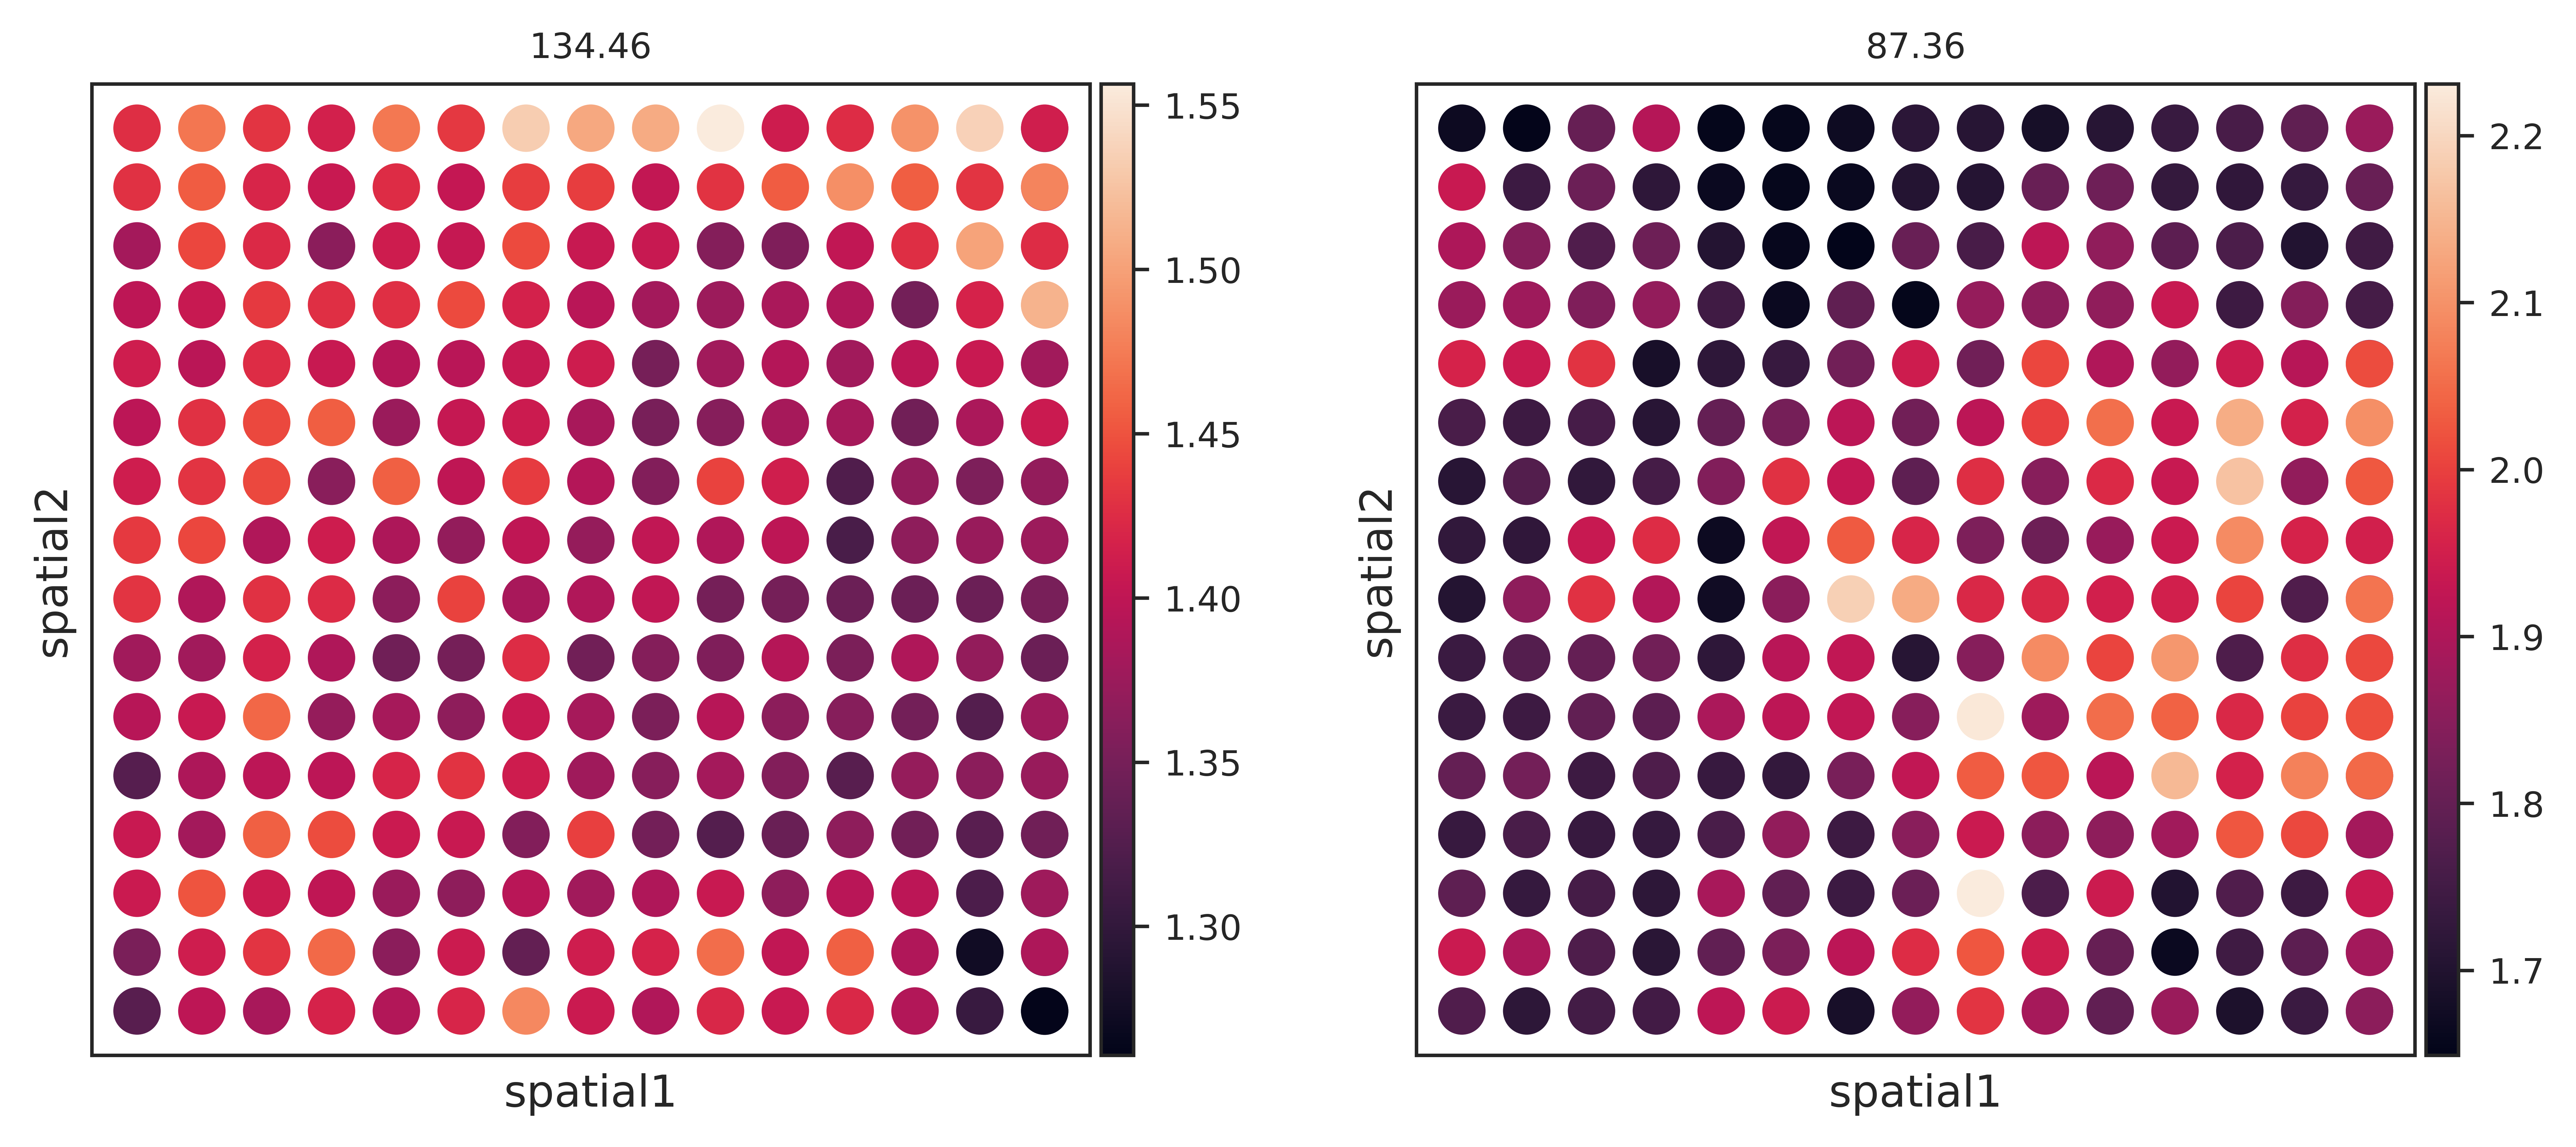

In [12]:
sc.pl.embedding(a_grid,basis='spatial',color=['134.46','87.36'])

### define flow function 

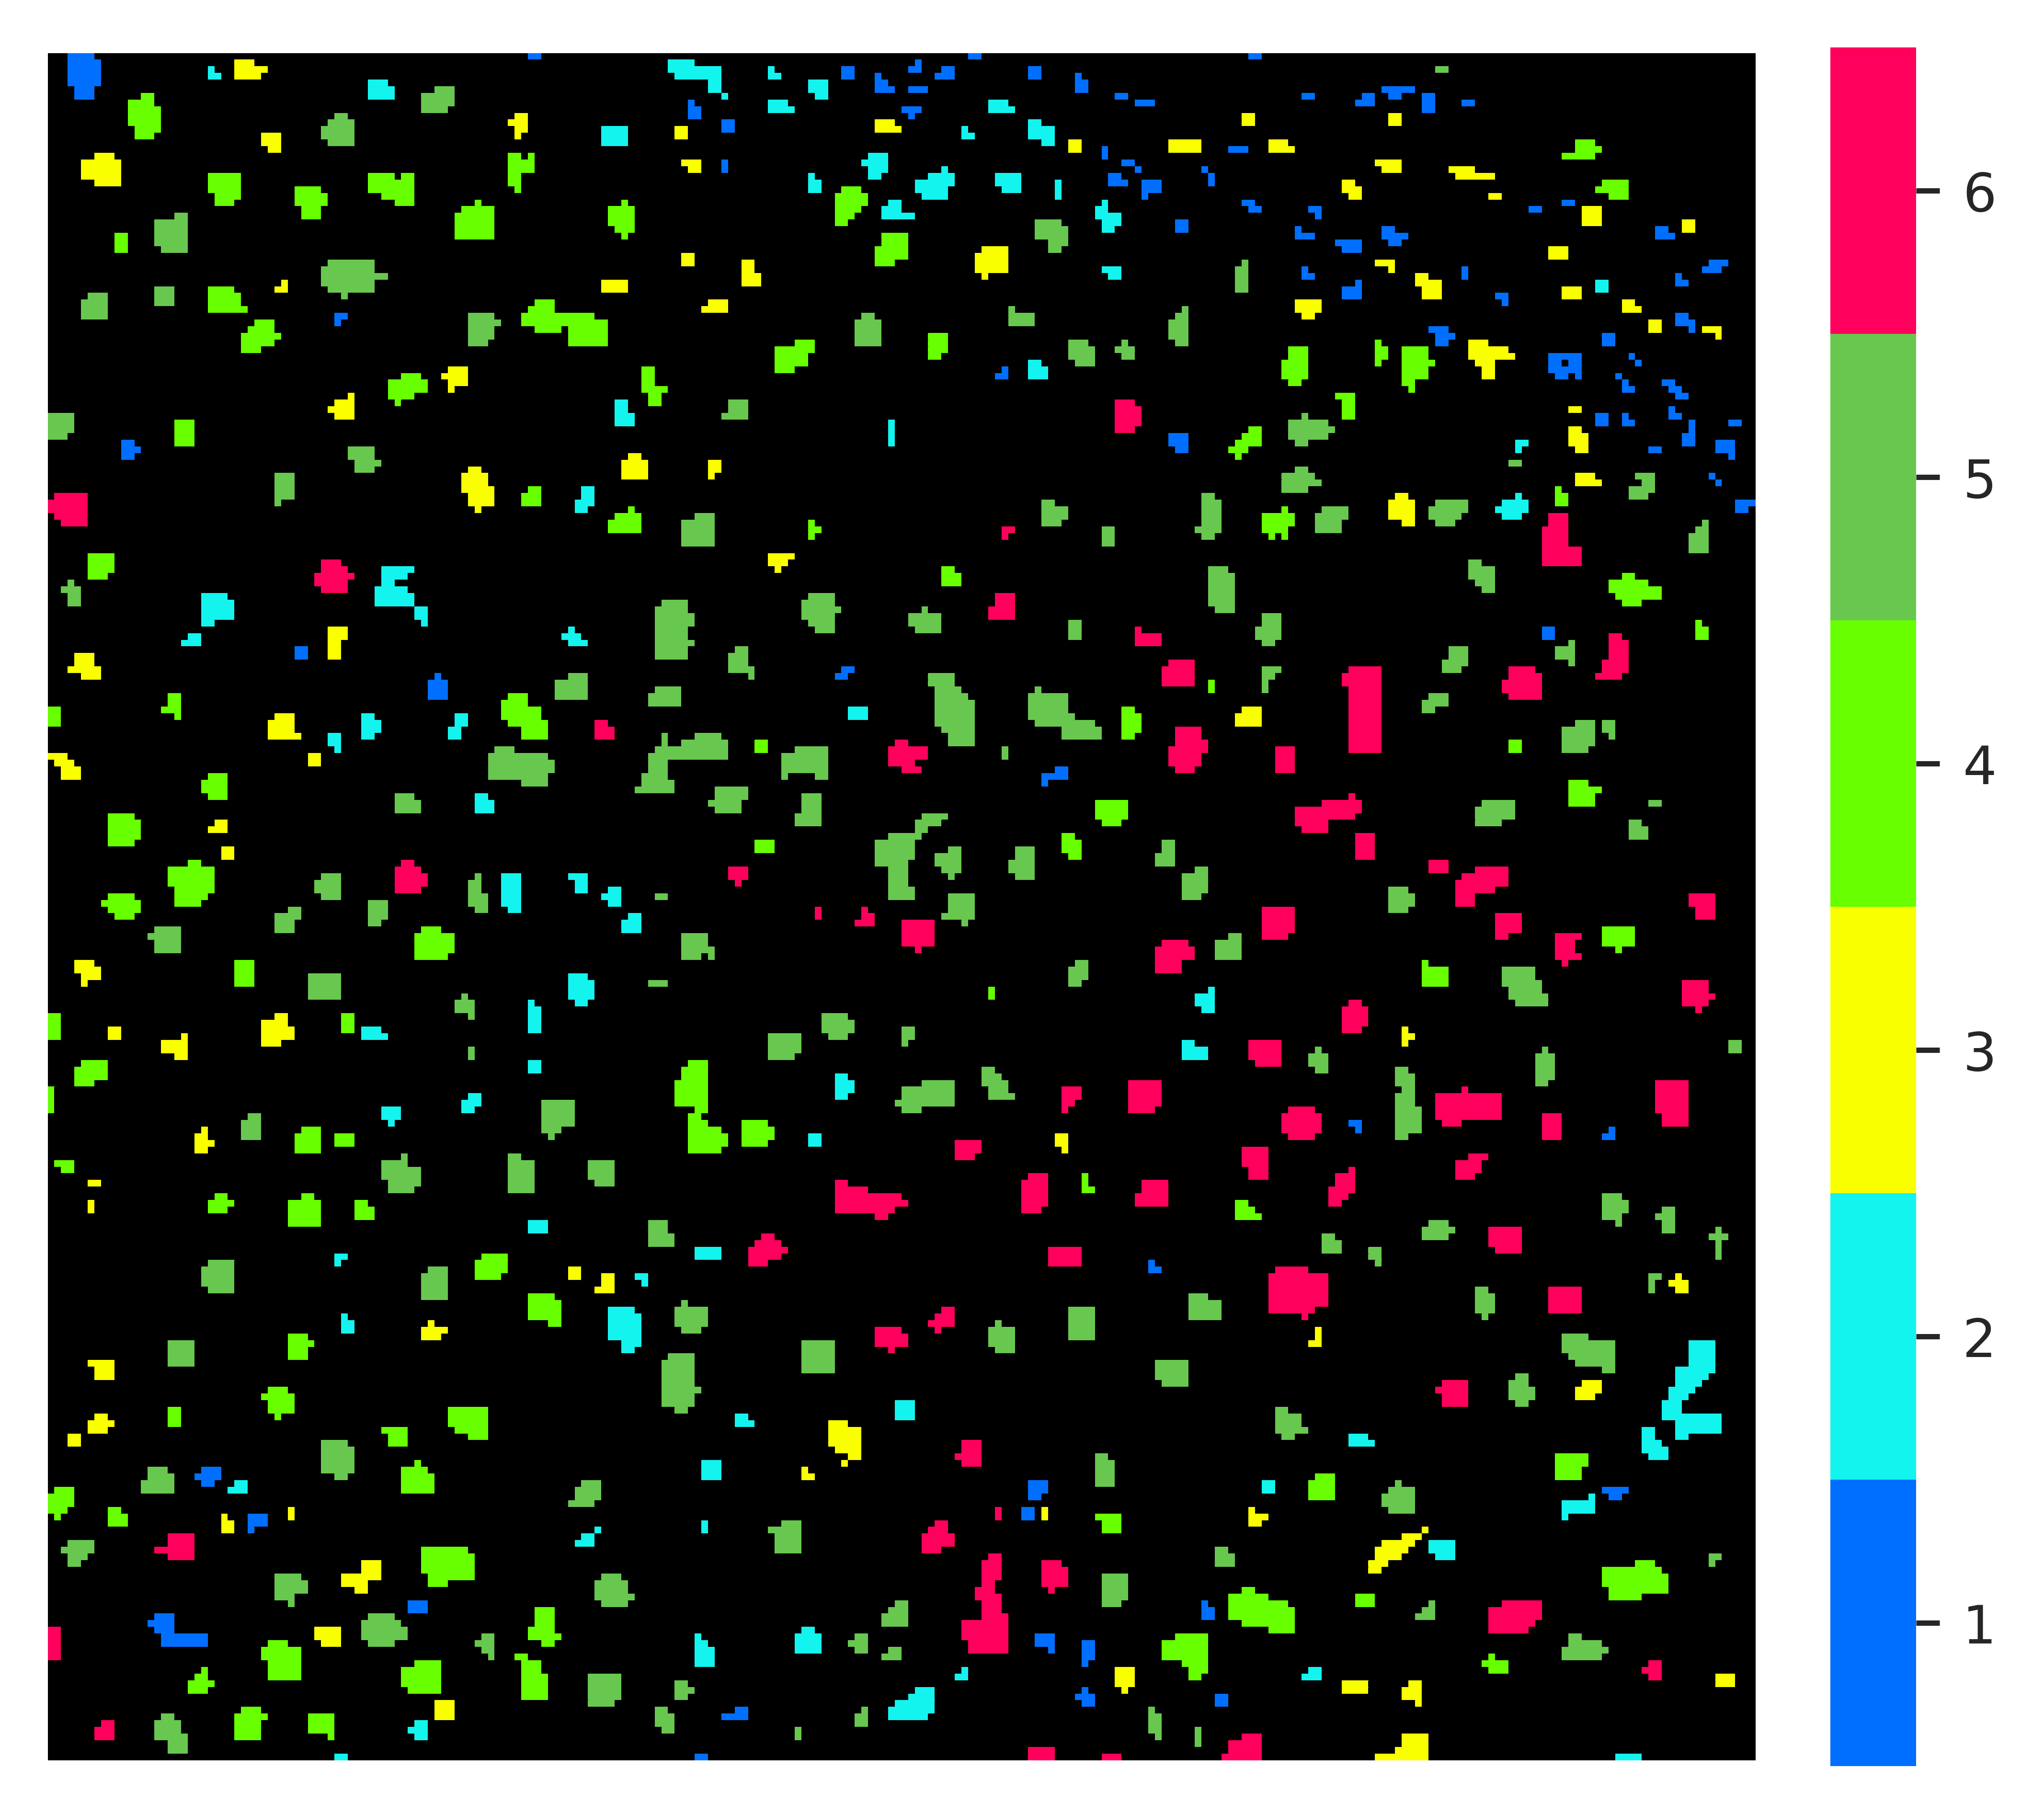

In [18]:
cls_mat = SEAM.pl.Cluster(a,cls='final_cls',groups=range(6),method='mask',return_mat=True)

In [23]:
cls_mat_C1 = cls_mat.copy()
cls_mat_C1[cls_mat!=6]=0


In [28]:
a.uns['final_cls_colors']

array([[0.        , 0.43529412, 1.        ],
       [0.0745098 , 0.95686275, 0.9372549 ],
       [0.98039216, 1.        , 0.        ],
       [0.40784314, 1.        , 0.        ],
       [0.40784314, 0.78039216, 0.30980392],
       [1.        , 0.        , 0.36078431]])

In [29]:
labeling_plot_cmp = ['k']
labeling_plot_cmp.append(a.uns['final_cls_colors'][-1])

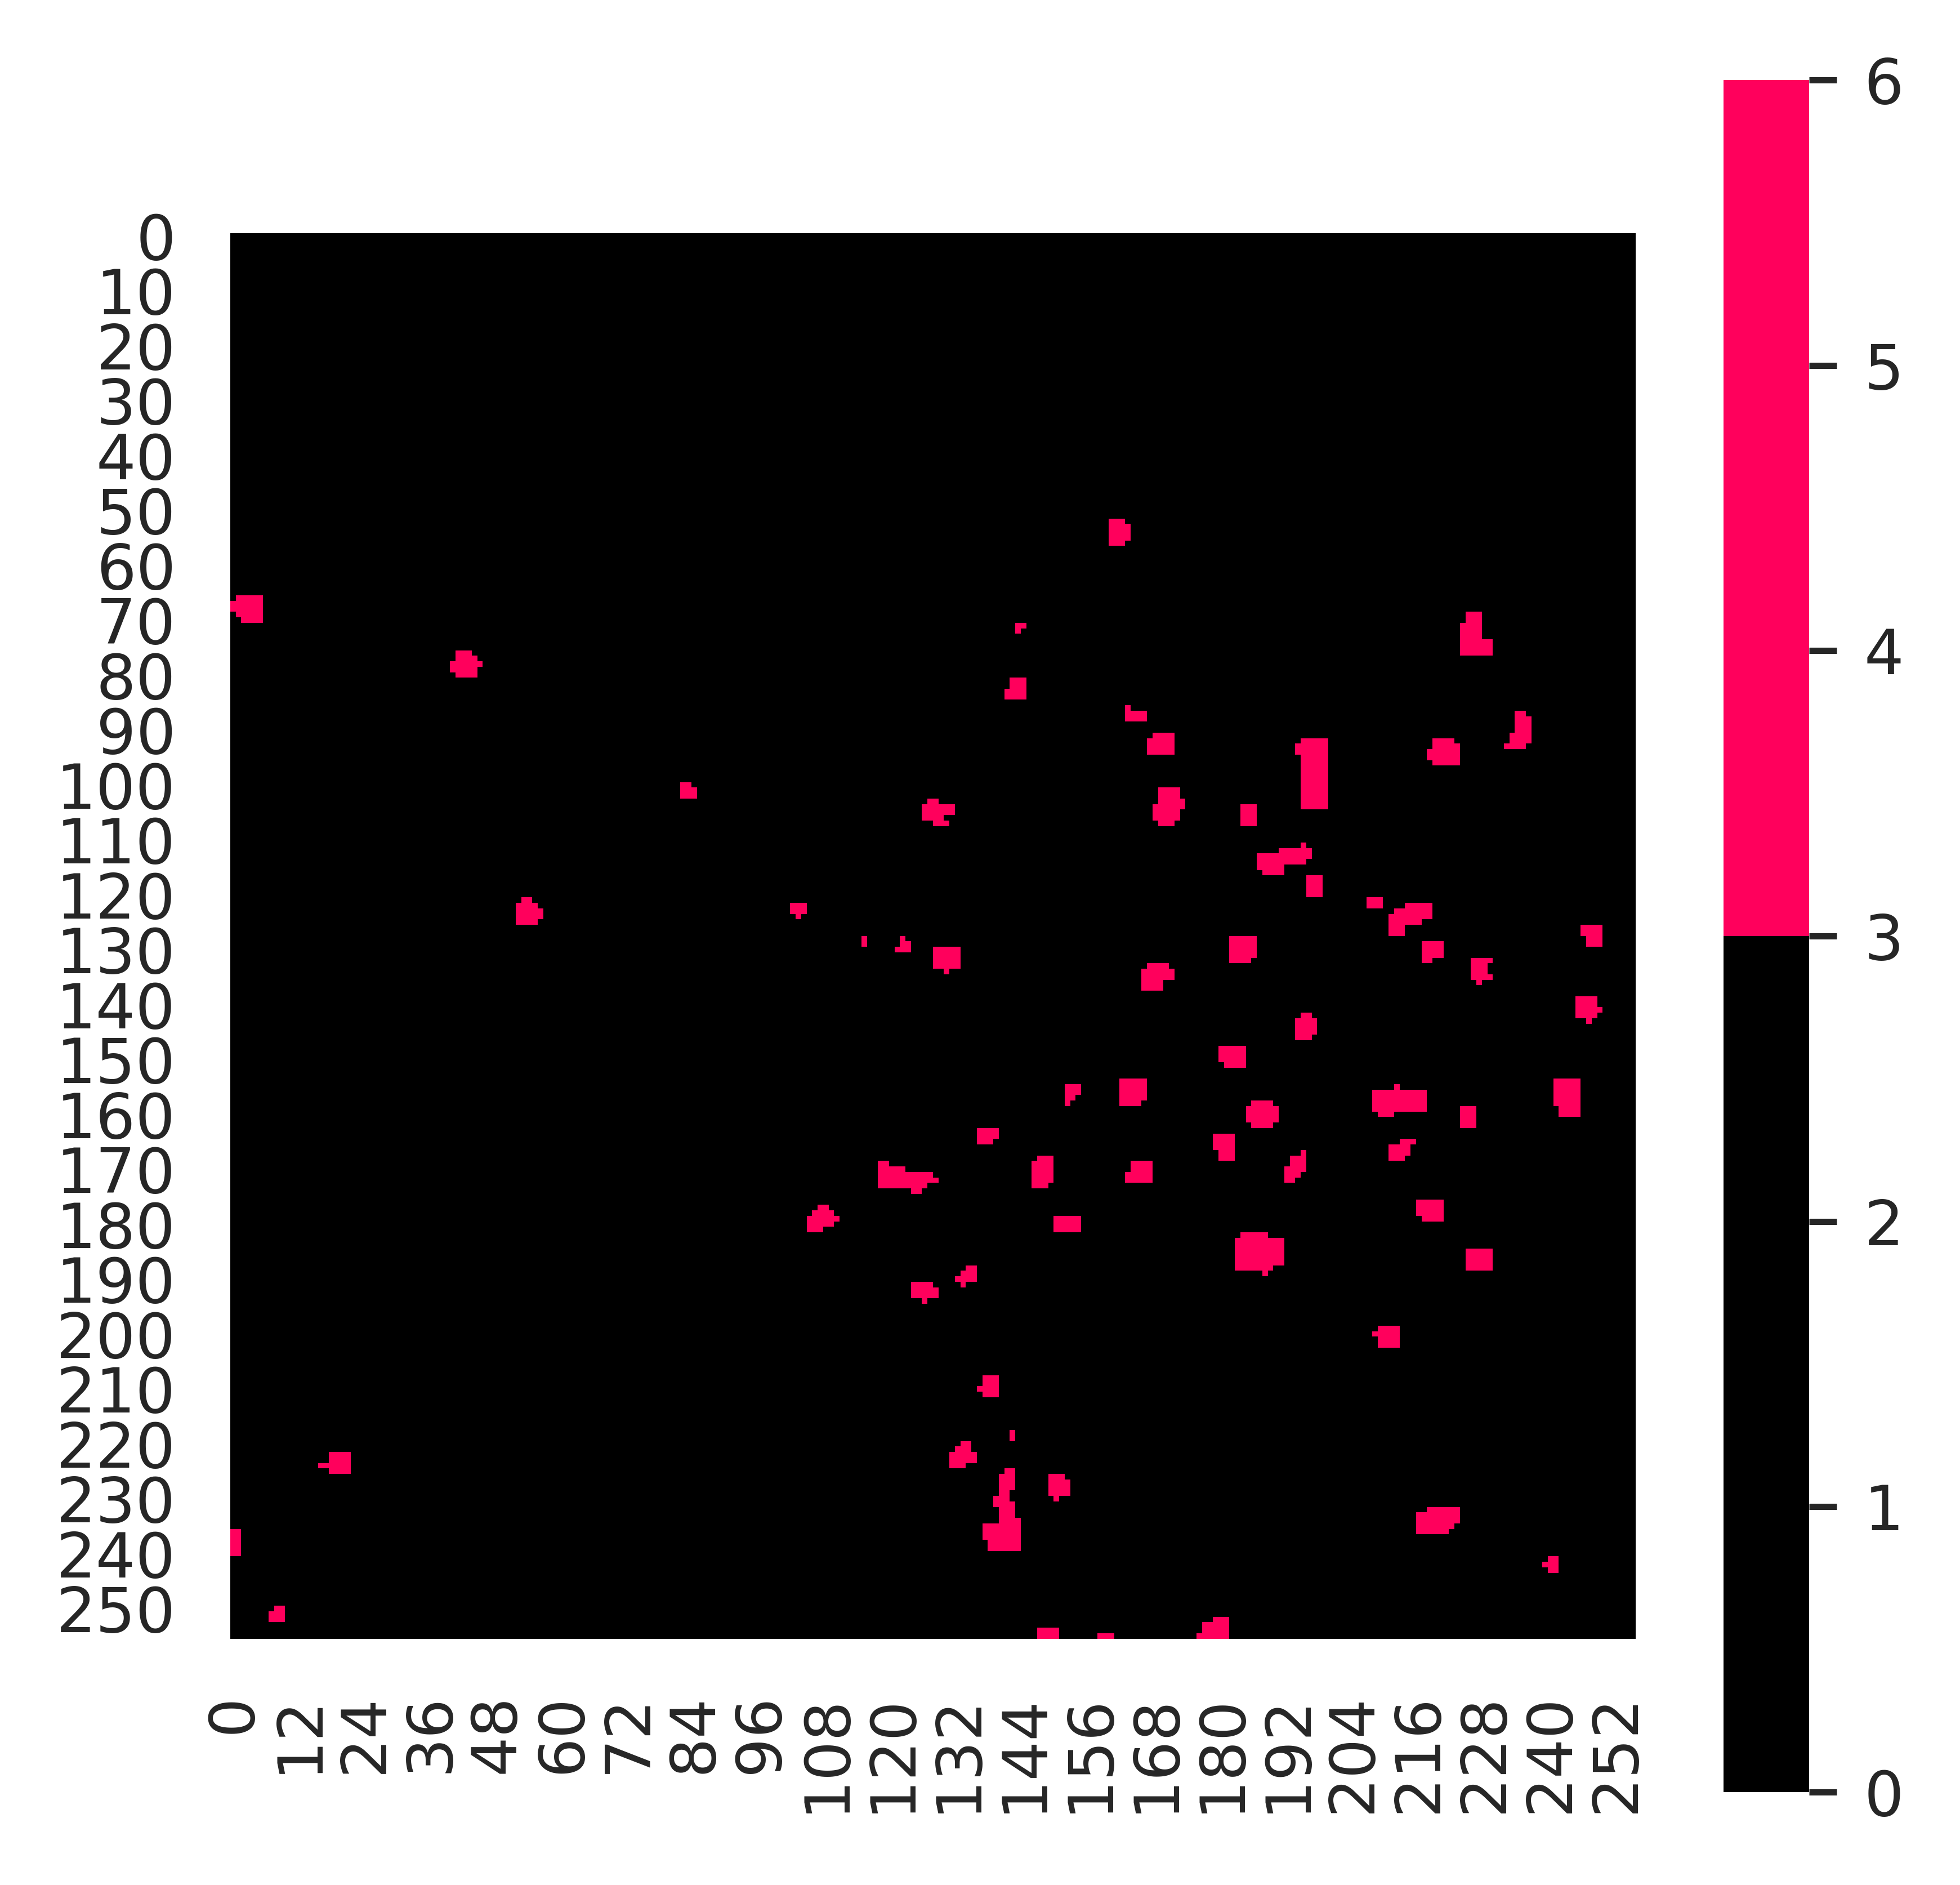

In [30]:
sns.heatmap(cls_mat_C1,cmap=labeling_plot_cmp,linewidths=0,linecolor='k',square=True)

In [35]:
def get_flow_by_m(m,save=None,scale=5):
    n_dot_row = int(np.sqrt(a_grid.shape[0]))

    # dpt_mat = np.array(a.obs['dpt_pseudotime'].copy()).reshape(n_dot_row,n_dot_row)
    # m = '134.48'
    # m = '255.83'
    # m = '87.36'
    dpt_mat = np.array(a_grid[:,m].X).reshape(n_dot_row,n_dot_row)
    x_mat = a_grid.obsm['spatial'][:,0].reshape(n_dot_row,n_dot_row)
    y_mat = a_grid.obsm['spatial'][:,1].reshape(n_dot_row,n_dot_row)
    # x_mat = 255-x_mat
    # x_mat = np.flipud(x_mat)
    # y_mat = np.flipud(y_mat)
    dpt_mat = np.flipud(dpt_mat)
    # dpt_mat = np.fliplr(dpt_mat)
    dx, dy = np.gradient(dpt_mat)


    cmp_list = 'gist_heat'
    # cmp_list = palettable.colorbrewer.diverging.Spectral_11.mpl_colormap
    # cmp_list = heatmap_cmp
    IMS_87 = a.uns['IMS'][:,np.where(a.var_names==m)].reshape(256,256)

    IMS_87_t = np.rot90(IMS_87,2)
    IMS_87_t = np.flip(IMS_87_t,axis=1)

    # ax = sc.pl.embedding(a,basis='spatial',color=['87.36'],show=False,color_map=SEAM.settings.heatmap_cmp)
    fig,ax = plt.subplots(1,1)
    ax.imshow((IMS_87_t),cmap=cmp_list)
#     ax=sns.heatmap(cls_mat_C1,cmap=labeling_plot_cmp,linewidths=0,linecolor='k',square=True,)    
    # ax.quiver(x_mat,y_mat,dy,dx,scale=5,color='w')
    # ax.quiver(x_mat,y_mat,dy,dx,angles='xy',color='w',scale=5,width=5)
    ax.quiver(x_mat+7.5,y_mat,dy,dx,angles='xy',color='w',scale=scale,linewidths=0.7)
    ax.set_title('m/z '+m)
    ax.axis('off')
    if save is None:
        plt.show()
    else:
        plt.savefig(save,transparent=False,format='png',bbox_inches='tight')

### multiple m

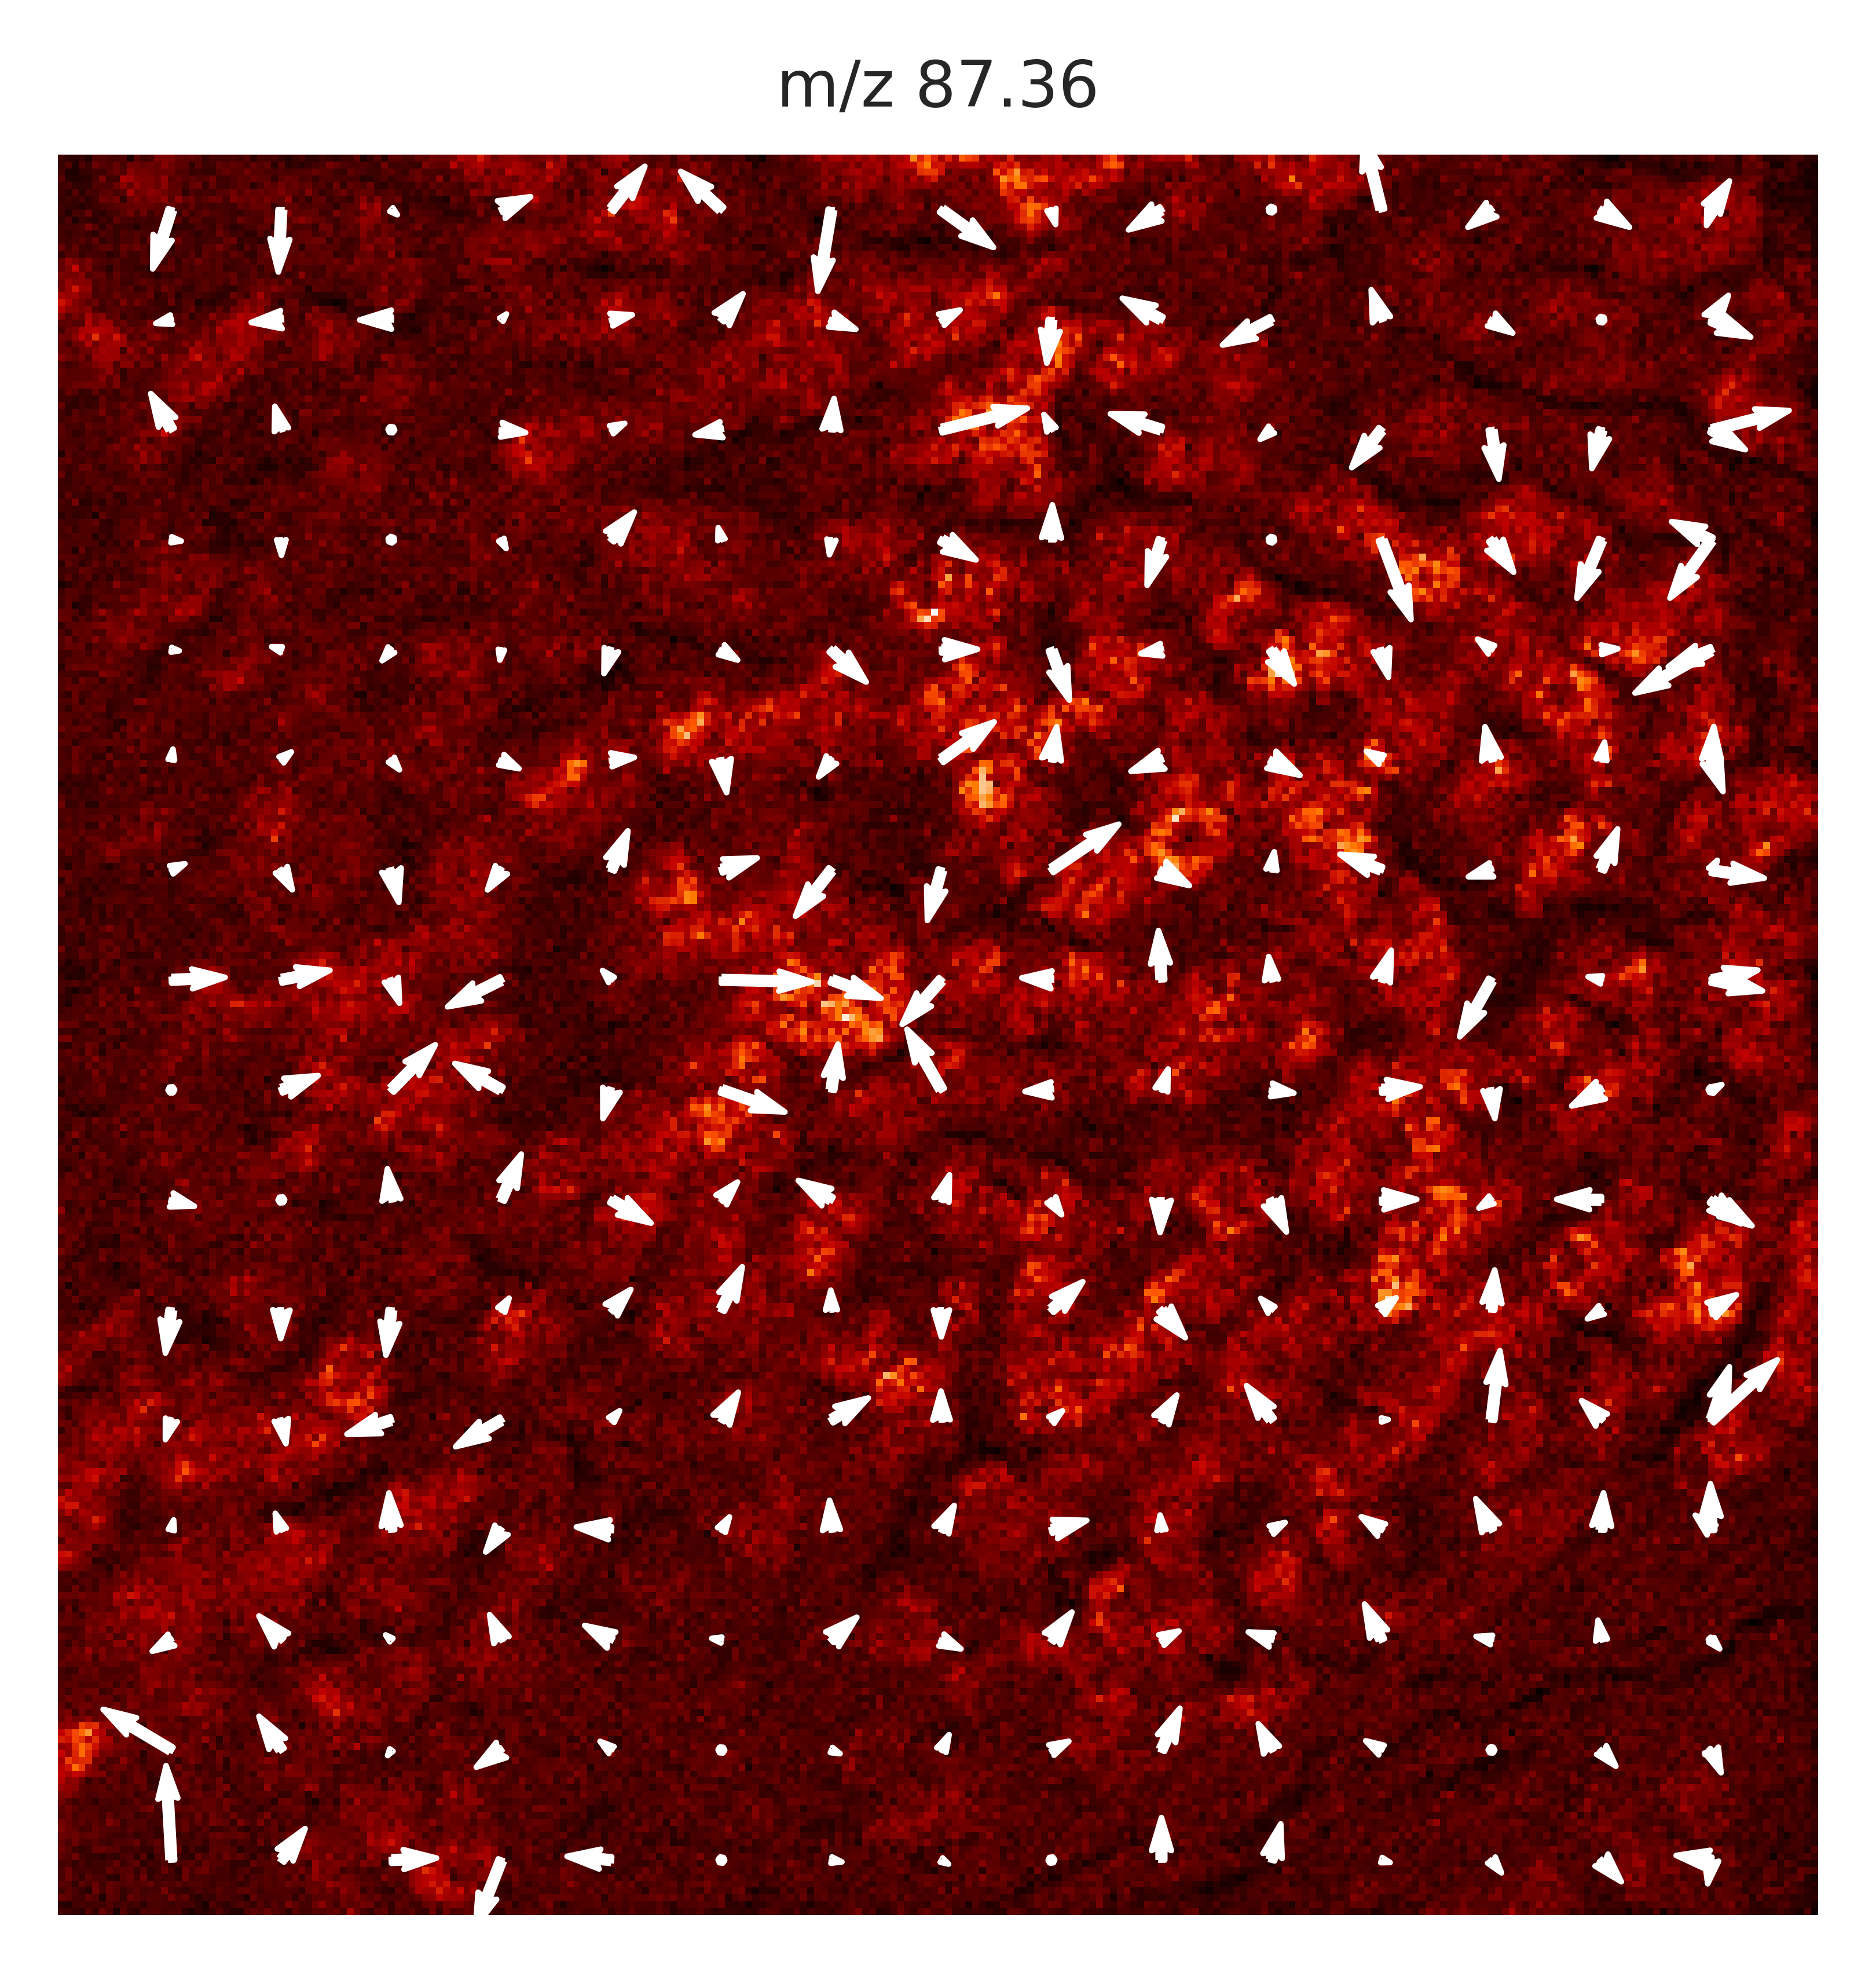

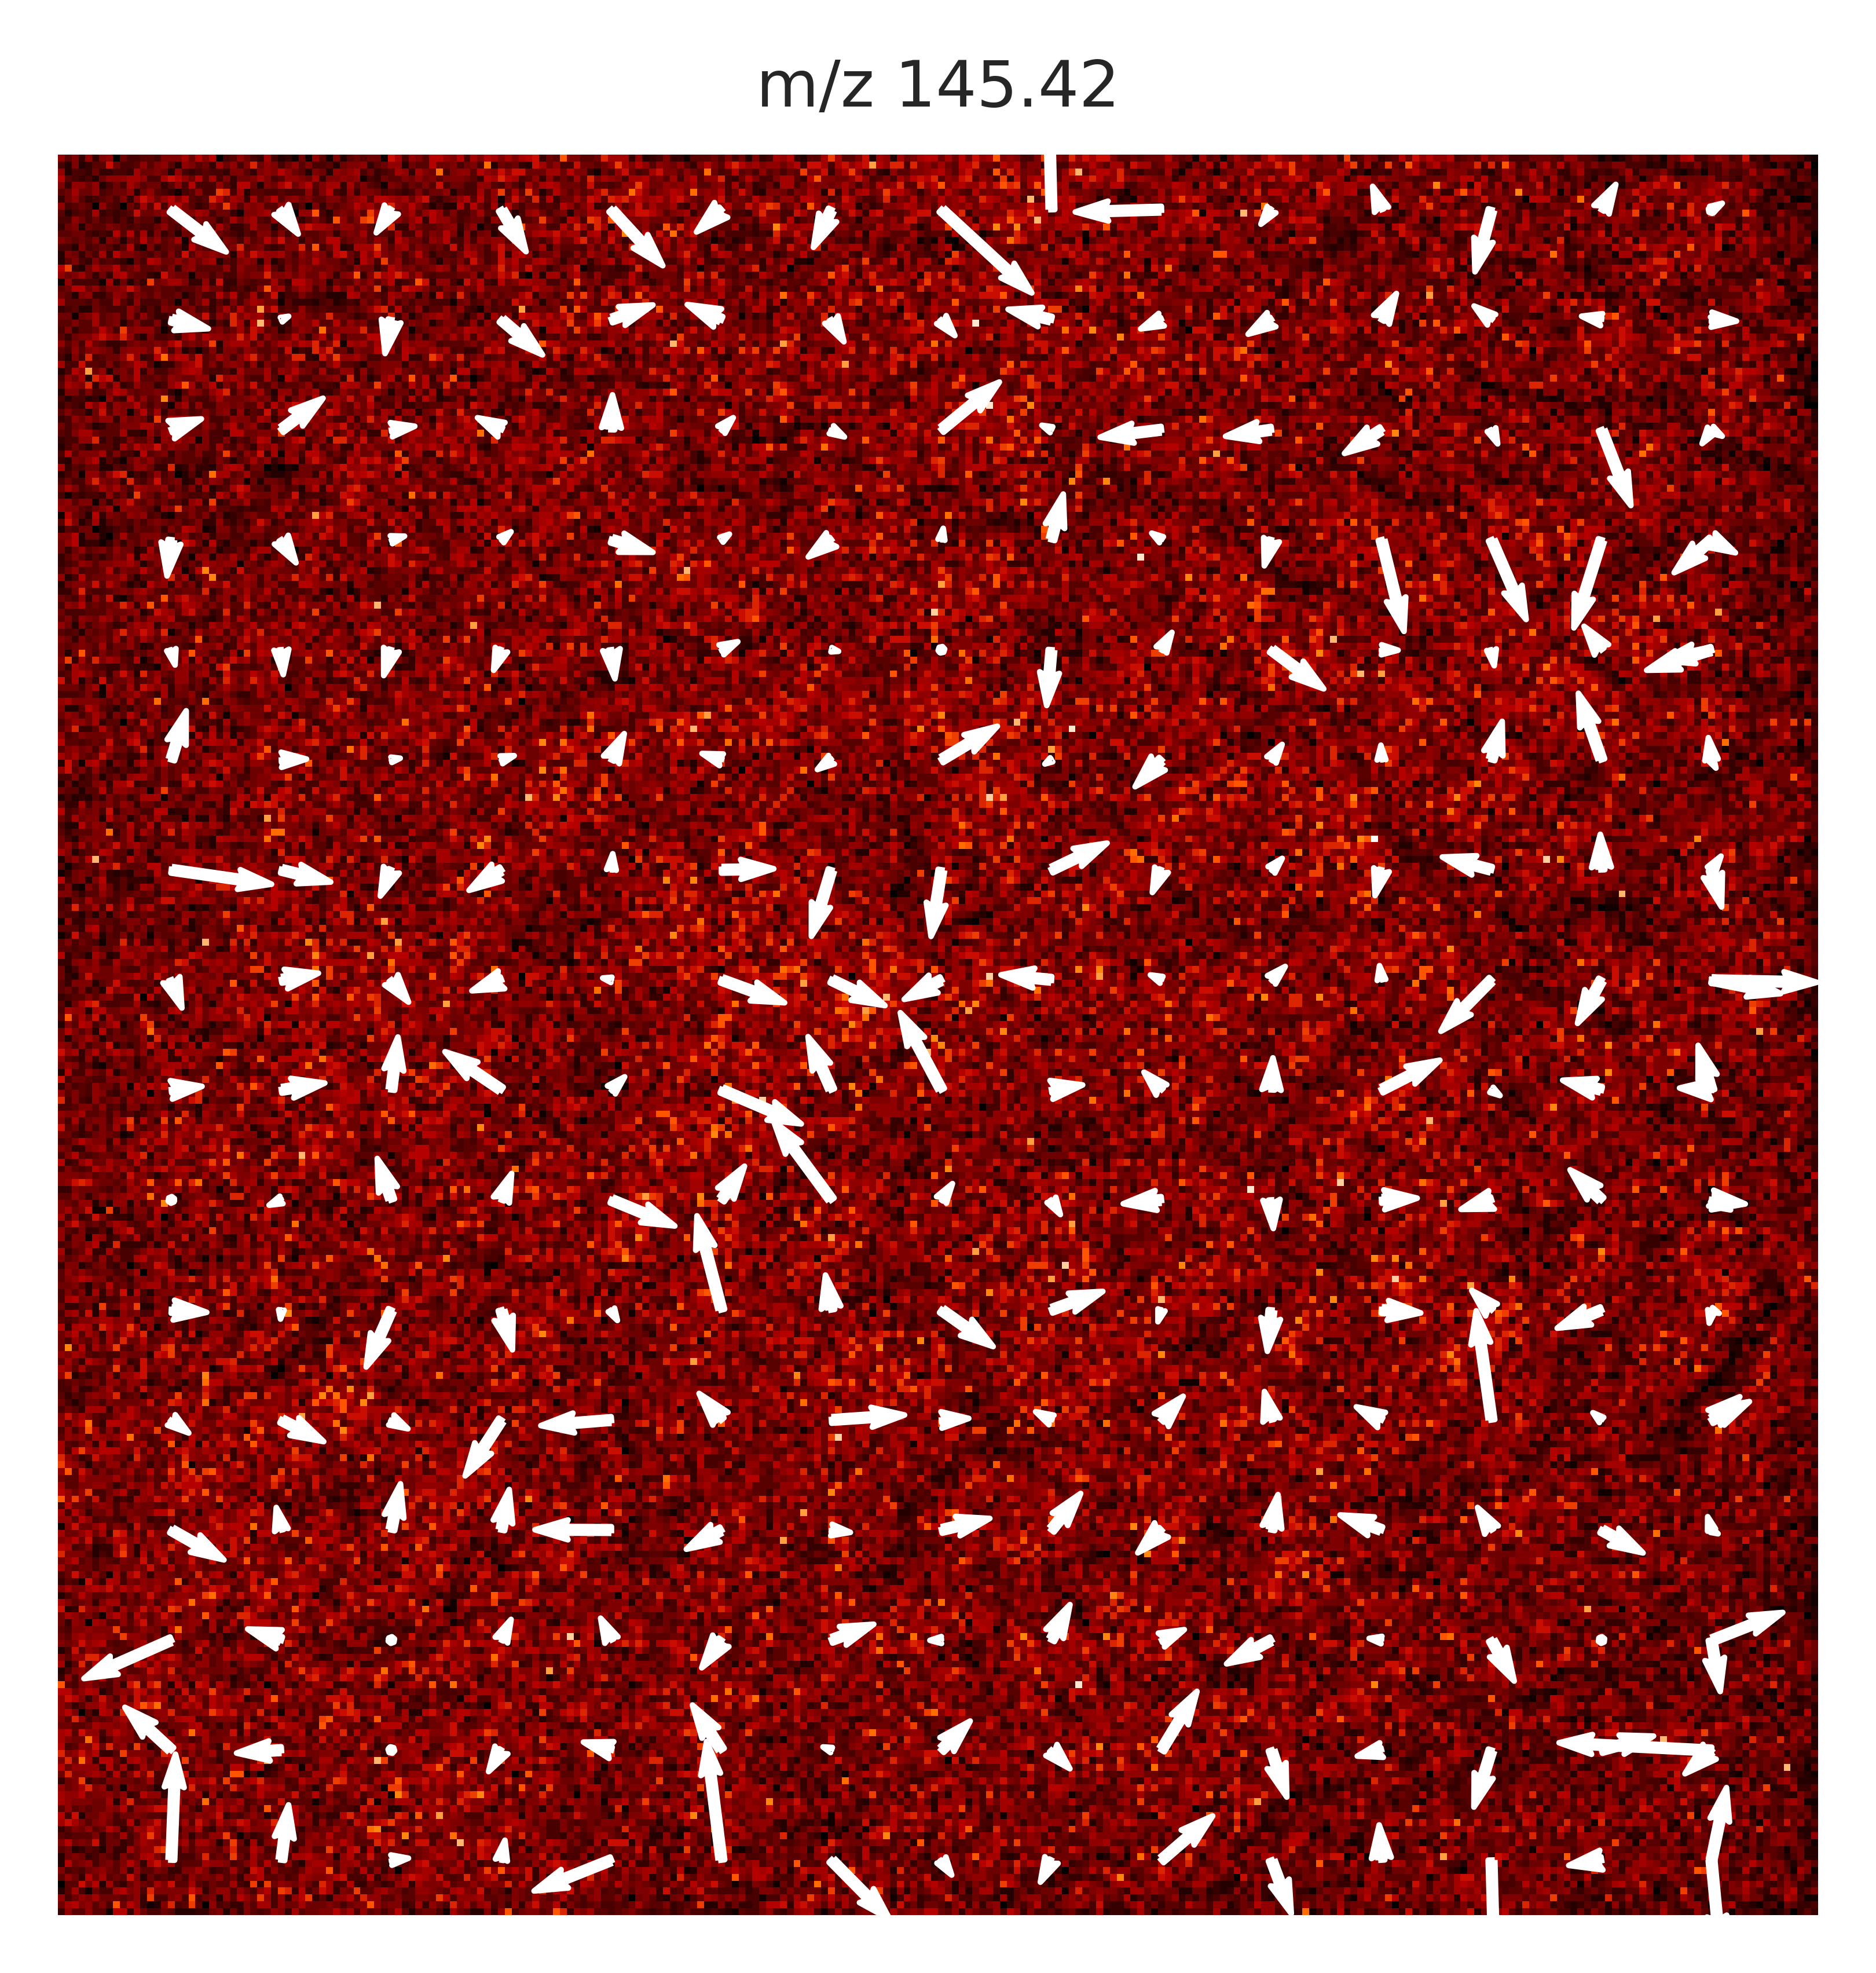

In [36]:
m_list = [
#     '55.03','57.02','58.02','59.02','69.01','71.03','73.03','87.03','101.05',
# #     '134.48',
#     '255.25','279.26','281.25','283.35'
    '87.36','145.42'
]
scale_list= [
    5,0.7
]
for i in range(len(m_list)):
    m = m_list[i]
    save_path = 'flow_figure/grid16_revision/{0}.png'.format(m)
    get_flow_by_m(m,None,scale_list[i])

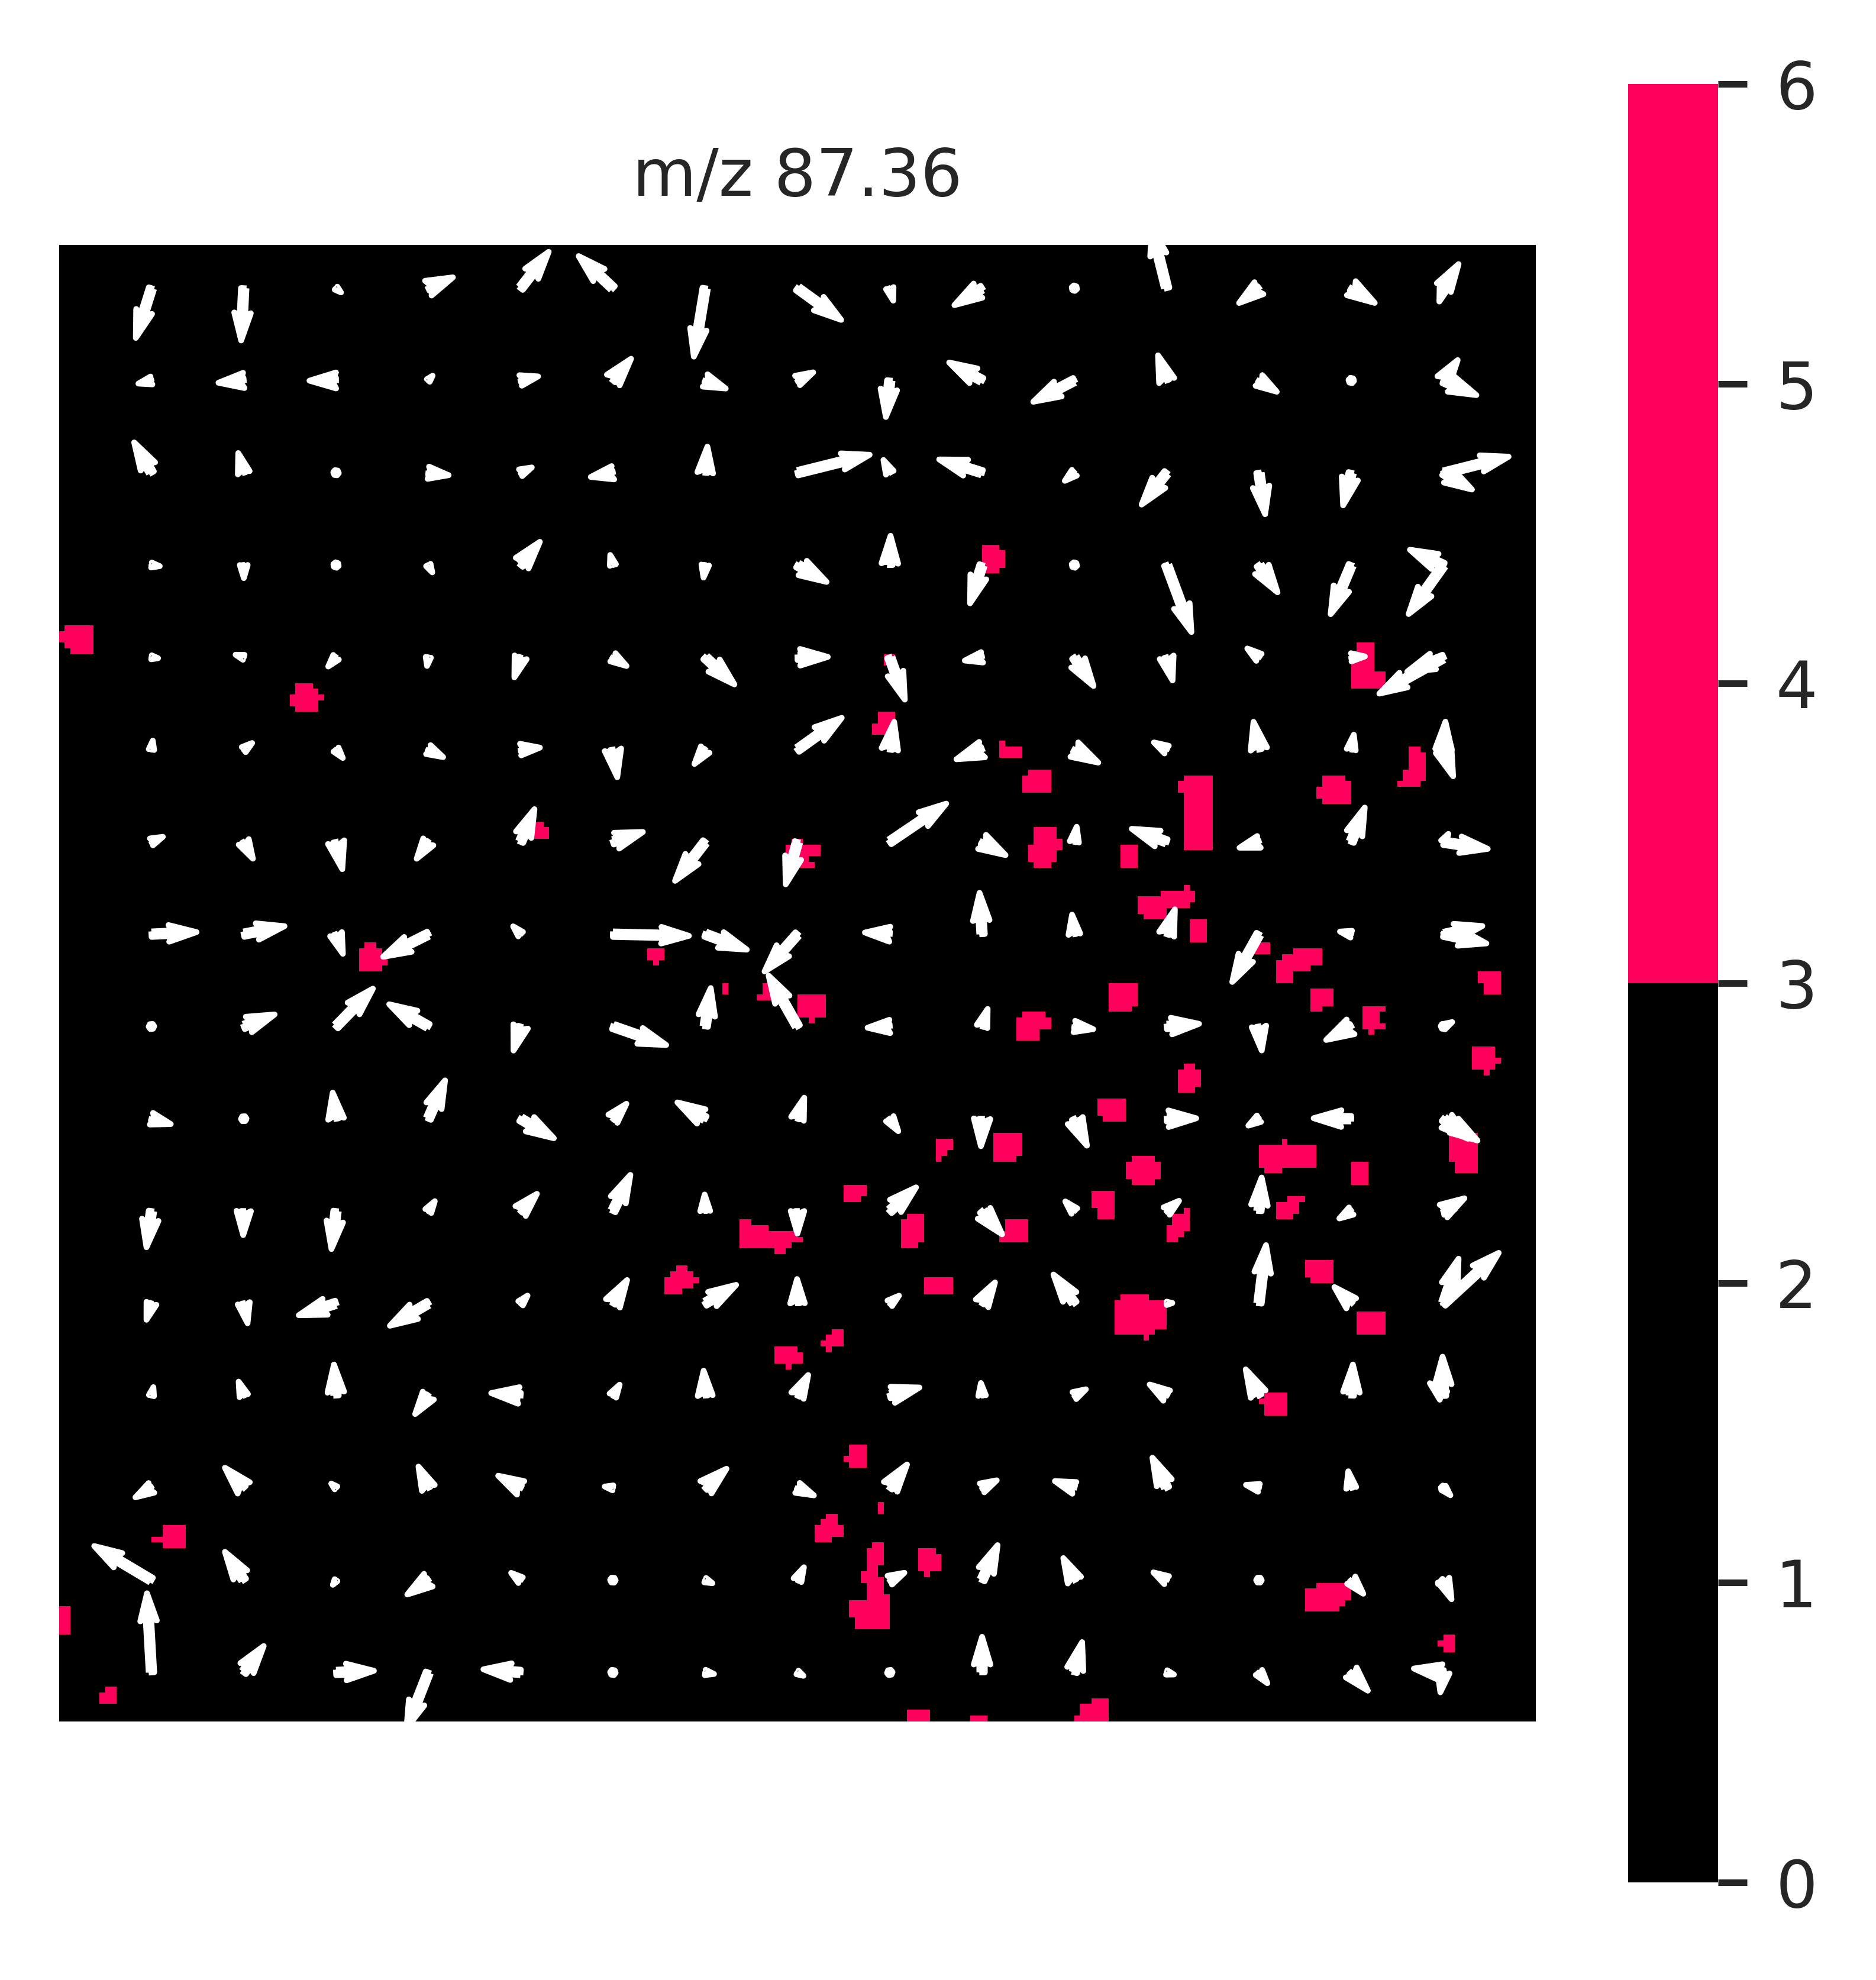

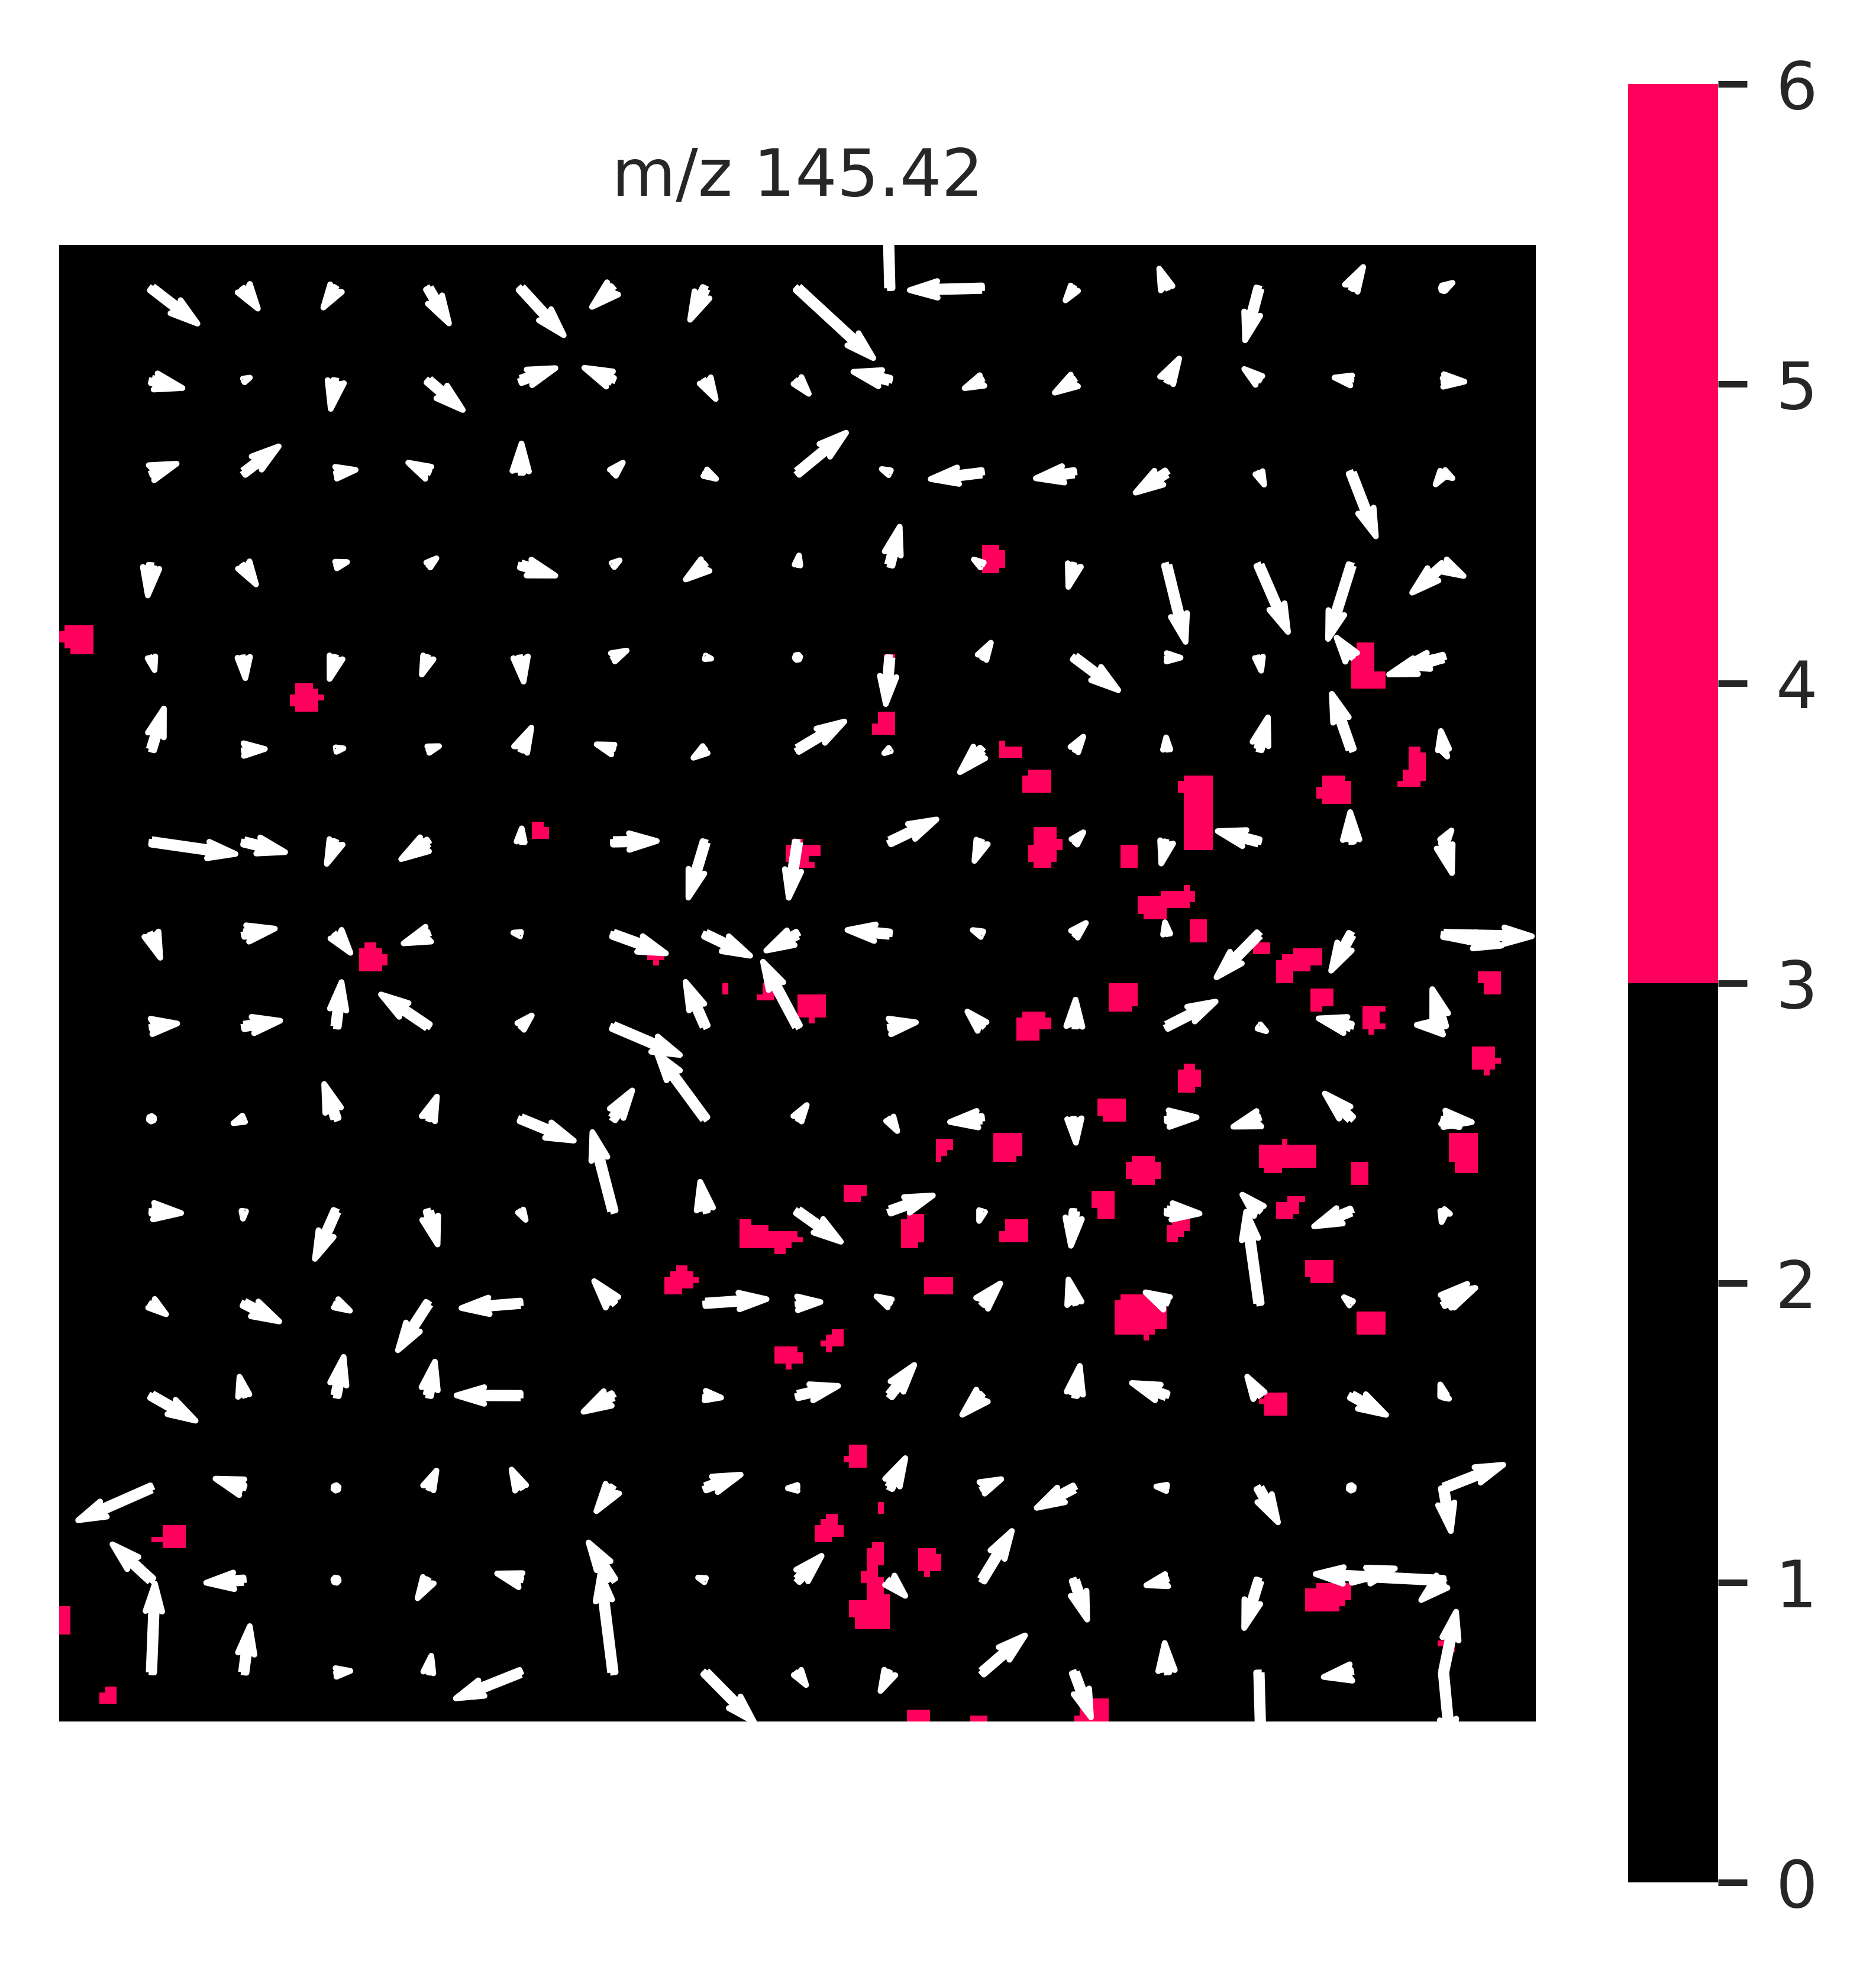

In [34]:
m_list = [
#     '55.03','57.02','58.02','59.02','69.01','71.03','73.03','87.03','101.05',
# #     '134.48',
#     '255.25','279.26','281.25','283.35'
    '87.36','145.42'
]
scale_list= [
    5,0.7
]
for i in range(len(m_list)):
    m = m_list[i]
    save_path = 'flow_figure/grid16_revision/{0}.png'.format(m)
    get_flow_by_m(m,None,scale_list[i])